#Finding the Parameters of a Known Exoplanet Transit Model

This notebook will serve as a code base for working through raw exoplanet transit data to eventually compute the parameters for the transit model. 

There are three main sections of this notebook:


1.   Manually fitting parameters to the transit data using the BATMAN model to find a suitable initial guess for the minimize function, plotting this lightcurve over the transit data to assess accuracy.
2.   Using a minimize function to find more accurate parameters using the initial guess from the BATMAN model, again, plotting this lightcurve over the transit data to assess accuracy.
3. Folding this data onto itself using a value for the orbital period given by our minimize function.

Note: The Transit Least Squares function can fold the data for us and compute an accurate value for the transit period, but, in this notebook, I'll opt for manual solutions in order to aid my understanding of what we're trying to achieve. We can, however, use the TLS function to verify our calculations.

###Installing Dependencies

In [1]:
!pip install batman-package
!pip install astropy
!pip install transitleastsquares
from scipy.optimize import minimize
!python -c 'import batman;batman.test()'
import batman
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from transitleastsquares import transitleastsquares

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)



Starting tests...

Testing uniform limb darkening model...	
	test passed
Testing linear limb darkening model...	
	test passed
Testing quadratic limb darkening model...	
	test passed
Testing exponential limb darkening model...	
	test passed
Testing logarithmic limb darkening model...	
	test passed
Testing nonlinear limb darkening model...	
	test passed

Testing error tolerance...
	10.0 ppm passed
	1.0 ppm passed
	0.1 ppm passed
	0.01 ppm passed

Testing multithreading...
	test passed

Congratulations! all tests passed

  ____       ____
  )   \     /   (
   )_  \_V_/  _(
     )__   __(
        `-'


### Importing and Plotting Raw Transit Data

In [2]:
data = ascii.read("https://raw.githubusercontent.com/Hamza-Suleman/transiting-exoplanets/main/Transit_model_LC_data.txt?token=AV7T5IO5QYXVU75KGH3ODX3BRJ4RO")
print(data)

  time     flux  flux_err
-------- ------- --------
     0.0 0.99973  0.00097
 0.01501 0.99943  0.00071
 0.03002 1.00095  0.00072
 0.04502 1.00053  0.00083
 0.06003 1.00015  0.00069
 0.07504 1.00062  0.00088
 0.09005 0.99986  0.00064
 0.10505 1.00168  0.00062
 0.12006 1.00005  0.00073
 0.13507 0.99984  0.00093
     ...     ...      ...
29.84992 0.99858  0.00077
29.86493 0.99963  0.00091
29.87994  1.0007  0.00065
29.89495 0.99992  0.00084
29.90995 0.99992  0.00076
29.92496 0.99957   0.0007
29.93997 1.00093  0.00097
29.95498 1.00148  0.00099
29.96998  0.9987  0.00069
29.98499 1.00018  0.00083
    30.0 1.00051  0.00095
Length = 2000 rows


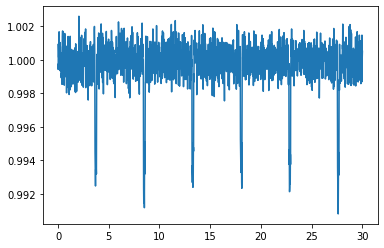

In [3]:
raw_time = []
raw_flux = []
raw_flux_err = []

for i in range(len(data)):
  raw_time.append(data[i][0])
  raw_flux.append(data[i][1])
  raw_flux_err.append(data[i][2])

raw_time = np.array(raw_time)
raw_flux = np.array(raw_flux)
raw_flux_err = np.array(raw_flux_err)

plt.plot(raw_time,raw_flux)

###Writing a Function to Plot a Lightcurve from Transit Parameters

In [4]:
def transit_plot(par,t,plottype="line",colour="b"):   #creating a function to take a list parameter inputs and plot a lightcurve
  params = batman.TransitParams()
  params.t0 = par[0]                      #time of inferior conjunction
  params.per = par[1]                     #orbital period
  params.rp = par[2]                      #planet radius (in units of stellar radii)
  params.a = par[3]                       #semi-major axis (in units of stellar radii)
  params.inc = par[4]                     #orbital inclination (in degrees)
  params.ecc = par[5]                     #eccentricity
  params.w = par[6]                       #longitude of periastron (in degrees)
  params.u = [0.1, 0.3]                   #limb darkening coefficients [u1, u2]
  params.limb_dark = "quadratic"          #limb darkening model
  m = batman.TransitModel(params, t)      #initializes model
  flux = m.light_curve(params)            #calculates light curve
  if plottype == "scatter":
    plt.scatter(t,flux,color=colour)
  else:
    plt.plot(t, flux,color=colour)
  plt.xlabel("Time")
  plt.ylabel("Relative flux")

The function transit_plot takes four arguments, the first of which is a list of parameters for the BATMAN model to create a lightcurve with. This will compute flux values for plotting against a list of time values that are also passed into the function. The function can then be passed additional arguments to specify the type of plot desired and also the colour. This will be useful when plotting a model lightcurve over the raw data on the same plot.

#### Testing Plotting Function

In [5]:
test_params = [0,1,0.1,15,87,0,90]
test_t = np.linspace(-0.05,0.05,100)

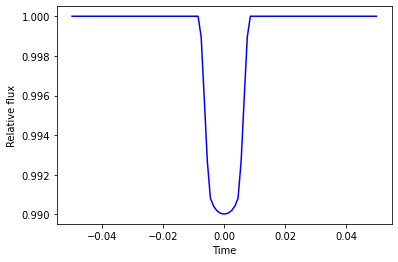

In [6]:
transit_plot(test_params,test_t)

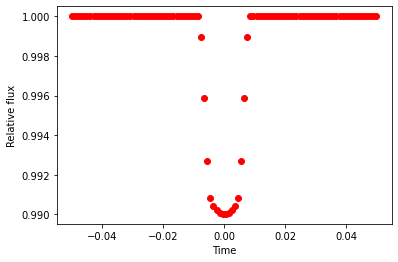

In [7]:
transit_plot(test_params,test_t,"scatter","r")

##Manually Fitting Transit Parameters to the Raw Data